# Grupo 2 - Actividad 3: Evaluación de la segmentación

El objetivo de esta actividad es probar y evaluar distintos segmentadores. Más concretamente, se va a realizar la segmentación para detectar la matrícula de una vehículo dentro de la imagen.

Una vez hecho esto, se evaluará el rendimiento de cada una de las segmentaciones frente a la imagen de ground truth.

### Integrantes del grupo y participación en reuniones

| Fecha | Lilian Gutiérrez Méndez | Gabriel López Solar | David Goñi Burgos | Alejandro Núñez Valle | Alberto Martín Montero |
|:---:|:---:|:---:|:---:|:---:|:---:|
| 09/06/2021 | OK | OK | OK | OK | OK |
| 13/06/2021 | OK | OK | OK | OK | OK |
| 15/06/2021 | OK | OK | OK | OK | OK |
| 16/06/2021 | OK | OK | OK | OK | OK |

#### Empezamos...

Lo primero será cargar la imagen con la que se probarán los segmentadores:

In [18]:
import cv2
import matplotlib.pyplot as plt

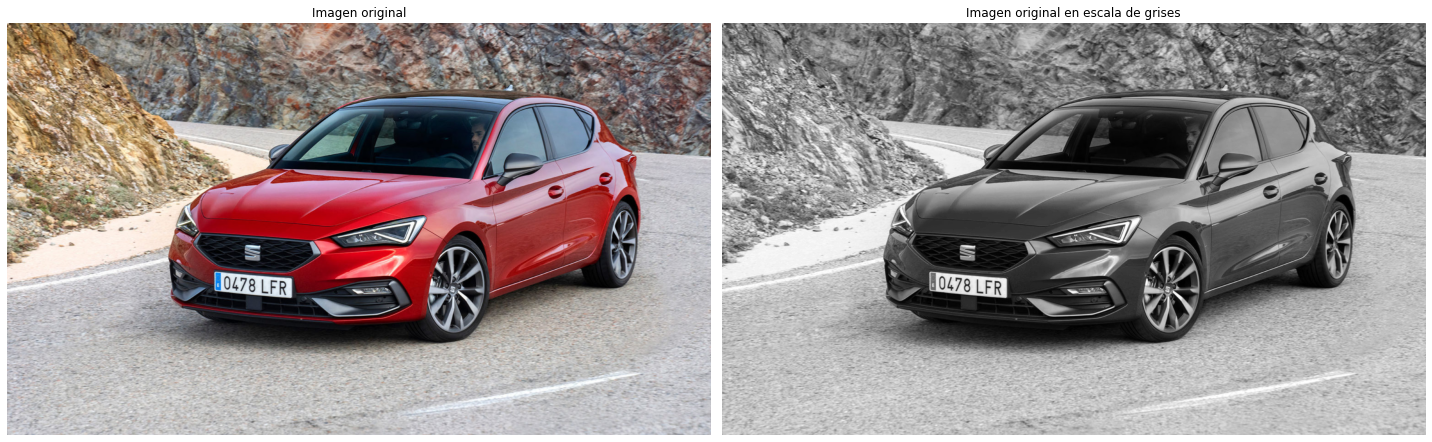

In [19]:
img = cv2.imread('coche.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Se transforma a escala de grises
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Visualización
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, figsize=(20, 8))
ax0.imshow(img), ax0.set_title('Imagen original')
ax0.axis('off')
ax1.imshow(img_gray, cmap='gray'), ax1.set_title('Imagen original en escala de grises')
ax1.axis('off')
fig.tight_layout()

## 1. MeanShift

Este método está basado en una segmentación por regiones. Implementado con _skimage.segmentation.quickshift()_

In [20]:
import numpy as np

from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import label2rgb

In [21]:
# Segmentación de la imagen
segmentos_qs = quickshift(img, kernel_size=13, max_dist=25, ratio=0.99, sigma=0)

# Se muestra el número de segmentos
print(f"Número de segmentos encontrados: {len(np.unique(segmentos_qs))}")

Número de segmentos encontrados: 213


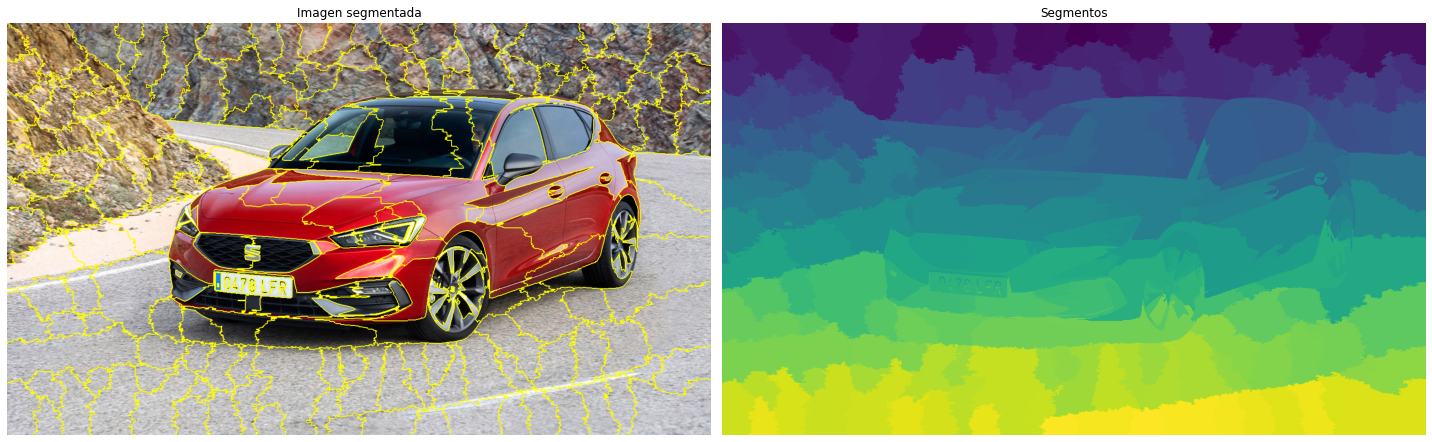

In [22]:
# Visualización de la imagen segmentada
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, figsize=(20, 8))
ax0.imshow(mark_boundaries(img, segmentos_qs)), ax0.set_title('Imagen segmentada')
ax0.axis('off')
ax1.imshow(segmentos_qs), ax1.set_title('Segmentos')
ax1.axis('off')
fig.tight_layout()

En esta parte, el usuario seleccionará los segmentos que deberán ser etiquetados como matrícula.

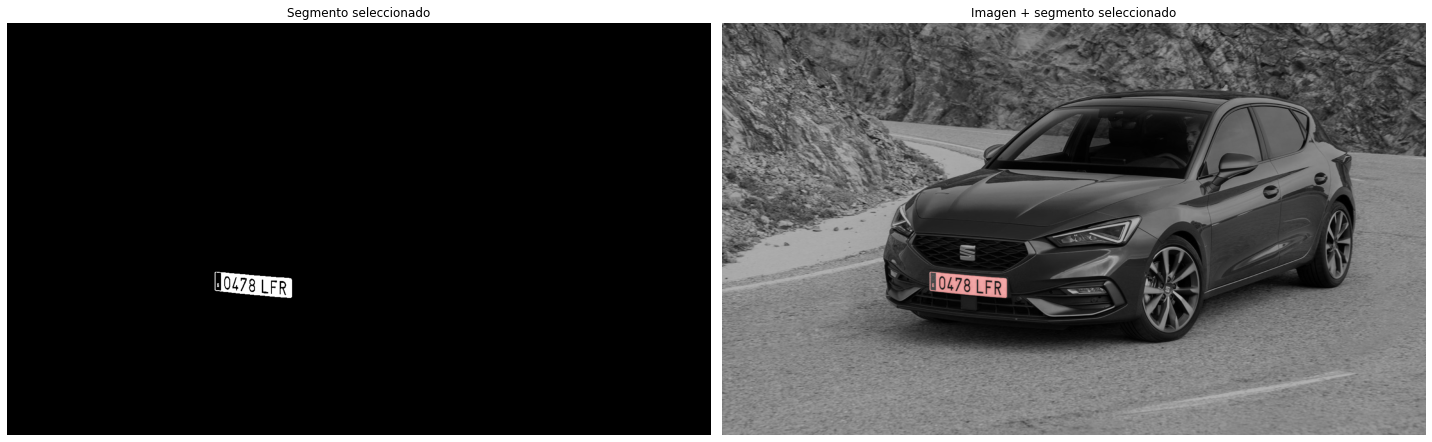

In [23]:
segmento_matricula_1 = segmentos_qs == 138
segmento_matricula_2 = segmentos_qs == 137
segmento_matricula_qs = segmento_matricula_1 + segmento_matricula_2

# Composición de la imagen original y el segmento seleccionado
img_qs = label2rgb(segmento_matricula_qs, image=img_gray, bg_label=0)

# Visualización del segmento seleccionado
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, figsize=(20, 8))
ax0.imshow(segmento_matricula_qs, cmap='gray'), ax0.set_title('Segmento seleccionado')
ax0.axis('off')
ax1.imshow(img_qs), ax1.set_title('Imagen + segmento seleccionado')
ax1.axis('off')
fig.tight_layout()

---

## 2. Watershed

Este método está basado en una segmentación por contornos. Implementado con _skimage.segmentation.watershed()_

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.filters
from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import watershed
from skimage.color import label2rgb

El primer paso es aplicar la detección de bordes con el filtro de Sobel sobre la imagen en escala de grises:

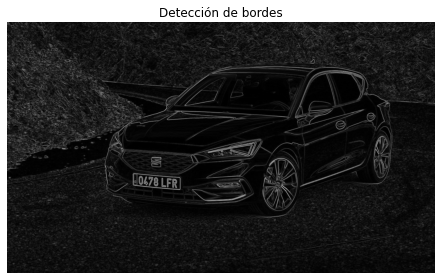

In [25]:
img_sobel = sobel(img_gray)

# Visualización
fig, ax = plt.subplots(ncols=1, figsize=(16, 4))
ax.imshow(img_sobel, cmap='gray'), ax.set_title('Detección de bordes')
ax.axis('off')
fig.tight_layout()

Se aplica una umbralización para definir el background y el foreground:

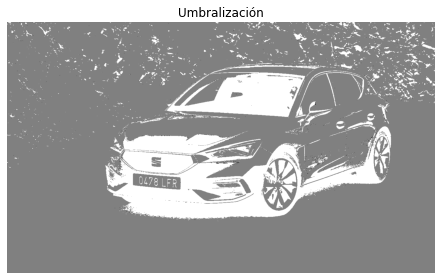

In [26]:
threshold = 70 # Valor del umbral
markers = np.zeros_like(img_gray)
foreground, background = 1, 2
markers[img_gray < threshold] = background
markers[img_gray > threshold] = foreground

# Visualización
fig, ax = plt.subplots(ncols=1, figsize=(16, 4))
ax.imshow(markers, cmap='gray'), ax.set_title('Umbralización')
ax.axis('off')
fig.tight_layout()

A partir de la detección de bordes y de la umbralización se lleva a cabo la segmentación:

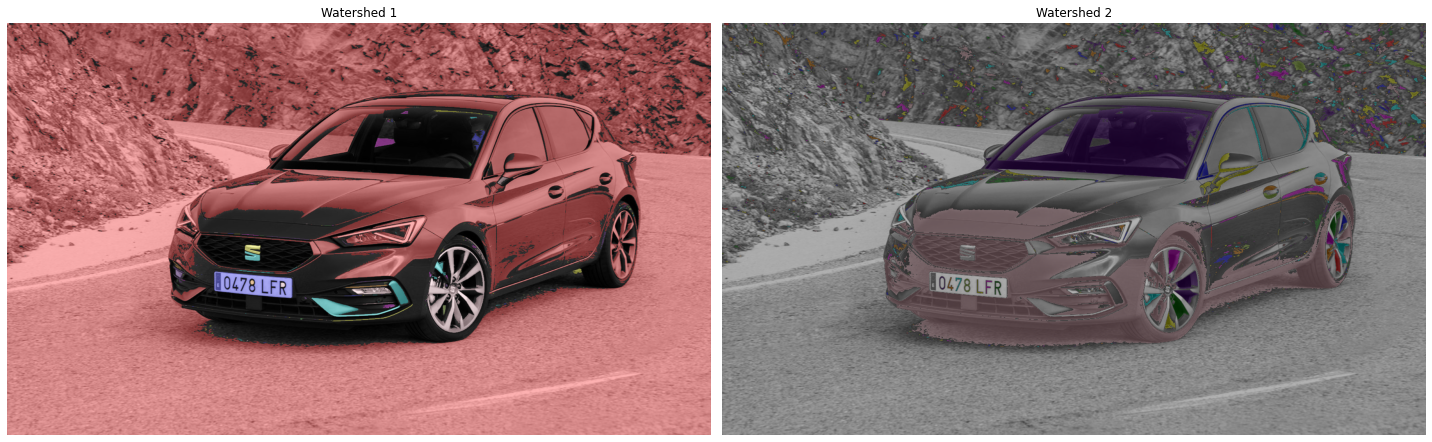

In [27]:
ws = watershed(img_sobel, markers)
seg_1 = label(ws == foreground)
seg_2 = label(ws == background)

# Visualización de ambas segmentaciones
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, figsize=(20, 8))
segmentacion_ws_1 = label2rgb(seg_1, image=img_gray, bg_label=0)
ax0.imshow(segmentacion_ws_1), ax0.set_title('Watershed 1')
ax0.axis('off')
segmentacion_ws_2 = label2rgb(seg_2, image=img_gray, bg_label=0)
ax1.imshow(segmentacion_ws_2), ax1.set_title('Watershed 2')
ax1.axis('off')
fig.tight_layout()

De nuevo, el usuario selecciona los segmentos para etiquetarlos como matrícula:

In [28]:
#Selección del pixel de la imagen donde está la matrícula (570,550)
print('Segmento matricula:', seg_1[570,550])

Segmento matricula: 202


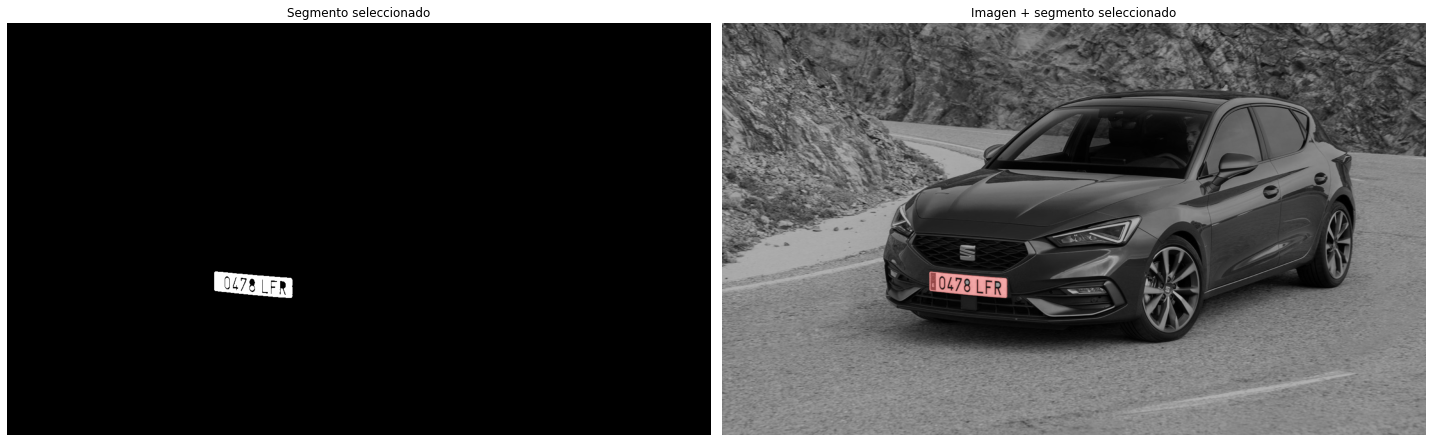

In [29]:
segmento_matricula_ws = seg_1 == 202

# Composición de la imagen original y el segmento seleccionado
img_ws = label2rgb(segmento_matricula_ws, image=img_gray, bg_label=0)

# Visualización del segmento seleccionado
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, figsize=(20, 8))
ax0.imshow(segmento_matricula_ws, cmap='gray'), ax0.set_title('Segmento seleccionado')
ax0.axis('off')
ax1.imshow(img_ws), ax1.set_title('Imagen + segmento seleccionado')
ax1.axis('off')
fig.tight_layout()

## 3. K-means & Graph Cut 

Implementado con _skimage.segmentation.slic()_ , _skimage.future.graph.rag_mean_color()_ y _skimage.future.graph.ncut()_

In [30]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [31]:
##Adaptado de: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_ncut.html

#Creamos las etiquetas usando k-means
etiquetas_kmeans= segmentation.slic(img, compactness=30, n_segments=500, start_label=1)

#Coloreamos las etiquetas con su respectivo color
etiquetas_kmeans_visualizacion = color.label2rgb(etiquetas_kmeans, img, kind='avg', bg_label=0)

#Creamos el grafo a partir de las etiquetas
grafo = graph.rag_mean_color(img, etiquetas_kmeans, mode='similarity')

#Obtenemos un graph cut normalizado a partir del grafo 
etiquetas_graphcut = graph.ncut(etiquetas_kmeans, grafo)

#Coloreamos las etiquetas con su respectivo color
etiquetas_graphcut_visualizacion = color.label2rgb(etiquetas_graphcut, img, kind='avg', bg_label=0)

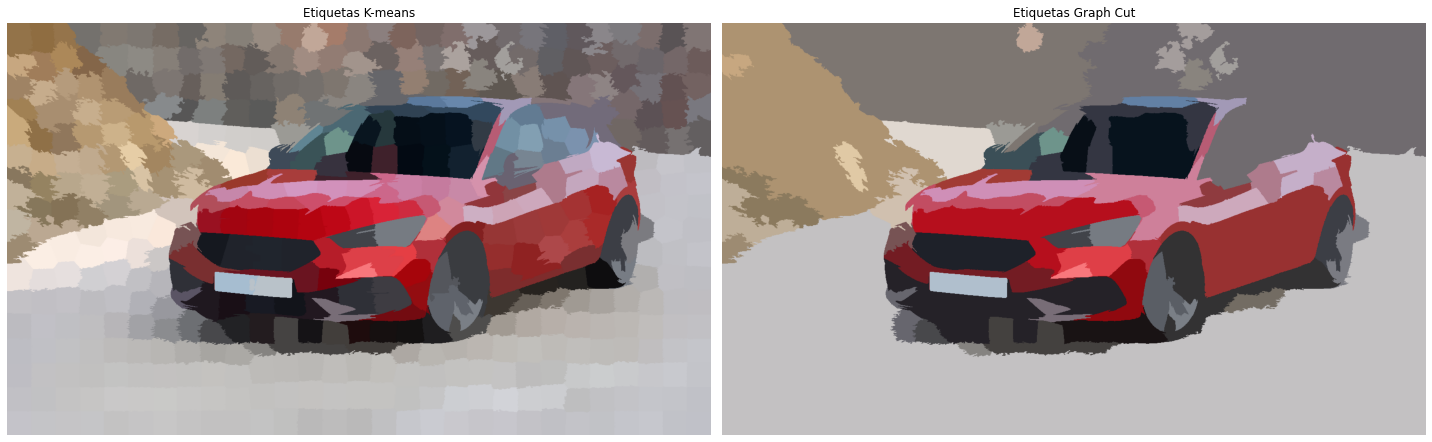

In [32]:
# Visualización de ambas etiquetas
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, figsize=(20, 8))
ax0.imshow(etiquetas_kmeans_visualizacion.astype(np.uint8)), ax0.set_title('Etiquetas K-means')
ax0.axis('off')

ax1.imshow(etiquetas_graphcut_visualizacion.astype(np.uint8)), ax1.set_title('Etiquetas Graph Cut')
ax1.axis('off')
fig.tight_layout()

Las dos imágenes anteriores reflejan muy bien como a partir de las etiquetas obtenidas a través de K-means se ha creado un grafo con su función de similaridad de tal forma que al obtener el graphcut, todas las etiquetas de un color parecido se han unido en una sola etiqueta.

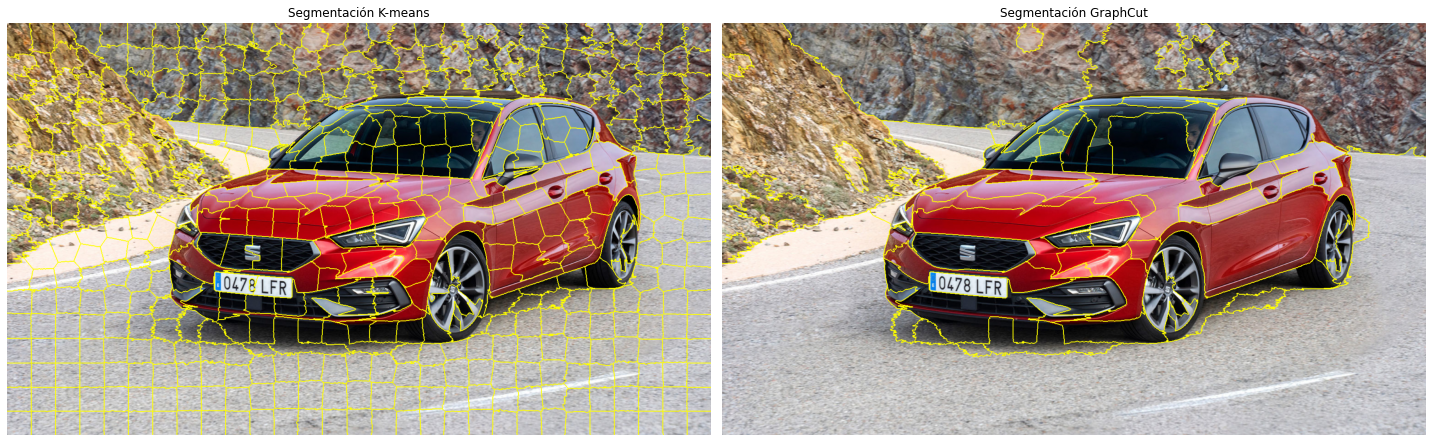

In [33]:
#Visualizacion de las segmentaciones en la imagen original
segmentacion_kmeans = segmentation.mark_boundaries( img, etiquetas_kmeans)
segmentacion_graphcut = segmentation.mark_boundaries( img, etiquetas_graphcut)

fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, figsize=(20, 8))
ax0.imshow(segmentacion_kmeans, cmap='gray'), ax0.set_title('Segmentación K-means')
ax0.axis('off')
ax1.imshow(segmentacion_graphcut), ax1.set_title('Segmentación GraphCut')
ax1.axis('off')
fig.tight_layout()

De nuevo, el usuario selecciona los segmentos para etiquetarlos como matrícula.

Como se puede ver en las imágenes anteriores la segmentación realizada por K-means divide la matrícula en dos segmentos, mientras que la de Graph Cut es solo un segmento.

In [34]:
#Selección del pixel de la imagen donde está la matrícula (570,550)
print('Segmento matricula 1 (K-means):', etiquetas_kmeans[570,550])
print('Segmento matricula 2 (K-means):', etiquetas_kmeans[570,500])
print('Segmento matricula (GraphCut):', etiquetas_graphcut[570,550])

Segmento matricula 1 (K-means): 295
Segmento matricula 2 (K-means): 294
Segmento matricula (GraphCut): 294


In [35]:
#Selección del segmento de matrícula con K-means
segmento_kmeans_1 = etiquetas_kmeans == 295
segmento_kmeans_2 = etiquetas_kmeans == 294
segmento_matricula_kmeans = segmento_kmeans_1 +segmento_kmeans_2

#Selección del segmento de matrícula con GraphCut
segmento_matricula_graphcut = etiquetas_graphcut == 294

In [36]:
#Comprobación de que ambos segmentos son iguales
matricula = segmento_matricula_graphcut == segmento_matricula_kmeans
segmentos_iguales = matricula.all()
if segmentos_iguales: 
     print('Ambos segmentos de matrícula son idénticos')

Ambos segmentos de matrícula son idénticos


Como era de esperar ambas segmentaciones de la matrícula son idénticas, ya que el graphcut se ha creado a partir de las etiquetas de k-means

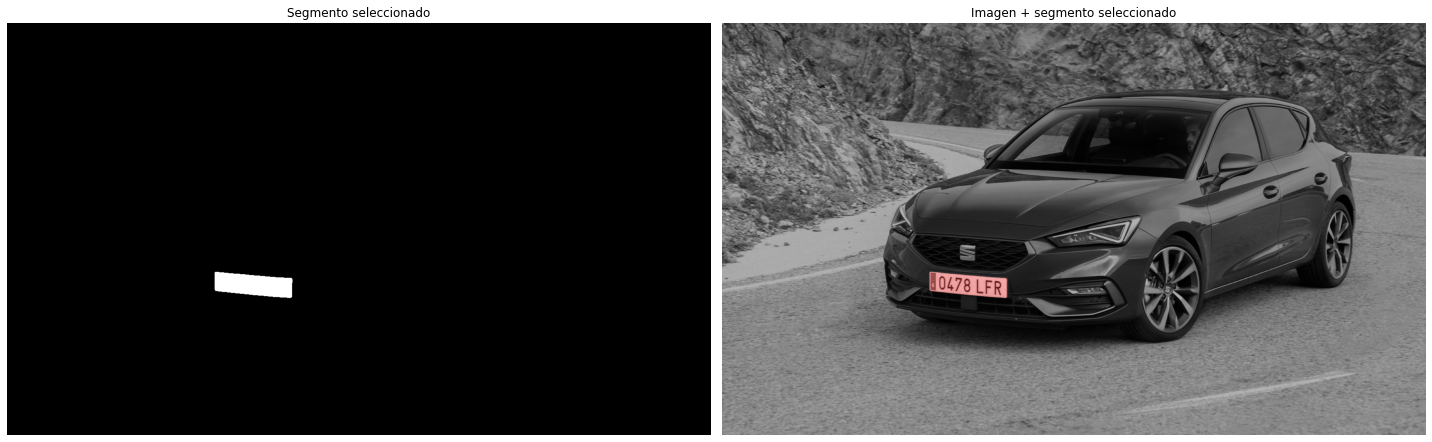

In [37]:
# Composición de la imagen original y el segmento seleccionado 
img_graphcut = color.label2rgb(segmento_matricula_graphcut, image=img_gray, bg_label=0)

# Visualización del segmento seleccionado 
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, figsize=(20, 8))
ax0.imshow(segmento_matricula_graphcut, cmap='gray'), ax0.set_title('Segmento seleccionado')
ax0.axis('off')
ax1.imshow(img_graphcut), ax1.set_title('Imagen + segmento seleccionado')
ax1.axis('off')
fig.tight_layout()

---

## Evaluación de los segmentadores

Se carga la imagen de ground truth y se normalizan los valores de los píxeles:

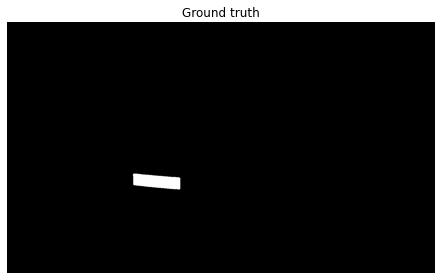

In [38]:
img_groundtruth = cv2.imread("coche_groundtruth.png")
img_groundtruth = cv2.cvtColor(img_groundtruth, cv2.COLOR_RGB2GRAY)

# Se escala de 255 a 1
img_groundtruth = img_groundtruth // 255
groundtruth_foreground_pixels = np.sum(img_groundtruth == 1)
groundtruth_background_pixels = np.sum(img_groundtruth == 0)

# Visualización
fig, ax = plt.subplots(ncols=1, figsize=(16, 4))
ax.imshow(img_groundtruth, cmap='gray'), ax.set_title('Ground truth')
ax.axis('off')
fig.tight_layout()

Se realiza el escalado en los segmentos de matrícula obtenido en cada uno de los segmentadores:

In [39]:
# MeanShift (QuickShift)
segmento_matricula_qs = segmento_matricula_qs.astype(int)
segmento_matricula_qs_foreground_pixels = np.sum(segmento_matricula_qs == 1)
segmento_matricula_qs_background_pixels = np.sum(segmento_matricula_qs == 0)

# Watershed
segmento_matricula_ws = segmento_matricula_ws.astype(int)
segmento_matricula_ws_foreground_pixels = np.sum(segmento_matricula_ws == 1)
segmento_matricula_ws_background_pixels = np.sum(segmento_matricula_ws == 0)

# Graphcut & K-means
segmento_matricula_graphcut = segmento_matricula_graphcut.astype(int)
segmento_matricula_graphcut_foreground_pixels = np.sum(segmento_matricula_graphcut == 1)
segmento_matricula_graphcut_background_pixels = np.sum(segmento_matricula_graphcut == 0)

# Se guardan los valores en una lista para aplicar las métricas
groundtruth_list = (img_groundtruth).flatten().tolist()
predicted_list_qs = (segmento_matricula_qs).flatten().tolist()
predicted_list_ws = (segmento_matricula_ws).flatten().tolist()
predicted_list_graphcut = (segmento_matricula_graphcut).flatten().tolist()

Se calculan las matrices de confusión y se aplican las métricas:

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

tn_qs, fp_qs, fn_qs, tp_qs  = confusion_matrix(groundtruth_list, predicted_list_qs).ravel()
tn_ws, fp_ws, fn_ws, tp_ws  = confusion_matrix(groundtruth_list, predicted_list_ws).ravel()
tn_graphcut, fp_graphcut, fn_graphcut, tp_graphcut = confusion_matrix(groundtruth_list, predicted_list_graphcut).ravel()

# MeanShift (QuickShift)
accuracy_qs = accuracy_score(groundtruth_list, predicted_list_qs)
recall_qs = recall_score(groundtruth_list, predicted_list_qs)
f1_qs = f1_score(groundtruth_list, predicted_list_qs)

print("- MeanShift (QuickShift)")
print("\tExactitud: " + str(round(accuracy_qs, 4)))
print("\tRecall: " + str(round(recall_qs, 4)))
print("\tF1: " + str(round(f1_qs, 4)))

# Watershed
accuracy_ws = accuracy_score(groundtruth_list, predicted_list_ws)
recall_ws = recall_score(groundtruth_list, predicted_list_ws)
f1_ws = f1_score(groundtruth_list, predicted_list_ws)

print("--------------------------")
print("- Watershed")
print("\tExactitud: " + str(round(accuracy_ws, 4)))
print("\tRecall: " + str(round(recall_ws, 4)))
print("\tF1: " + str(round(f1_ws, 4)))

# GraphCut 
accuracy_graphcut = accuracy_score(groundtruth_list, predicted_list_graphcut)
recall_graphcut = recall_score(groundtruth_list, predicted_list_graphcut)
f1_graphcut = f1_score(groundtruth_list, predicted_list_graphcut)

print("--------------------------")
print("- GraphCut")
print("\tExactitud: " + str(round(accuracy_graphcut, 4)))
print("\tRecall: " + str(round(recall_graphcut, 4)))
print("\tF1: " + str(round(f1_graphcut, 4)))

- MeanShift (QuickShift)
	Exactitud: 0.9989
	Recall: 0.7982
	F1: 0.8873
--------------------------
- Watershed
	Exactitud: 0.9993
	Recall: 0.8882
	F1: 0.926
--------------------------
- GraphCut
	Exactitud: 0.9999
	Recall: 0.9956
	F1: 0.994


---

Los valores de la métrica _accuracy_ es muy elevado por el alto número de TN que existen en la imagen. Por esto mismo, se han añadido los valores de _recall_ y _F1_. En el caso de MeanShift y Watershed, la métrica de recall muestra un valor menor ya que la segmentación excluye los caracteres de la matrícula.

Esta aplicación sería un paso previo a la técnica de reconocimiento de caracteres (OCR).